In [1]:
import pickle
import os 
import netCDF4 as netcdf
import skimage
import numpy as np
import torch 
import matplotlib.pyplot as plt

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))


# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]

######## Store Nan indices 

nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    

        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])        
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

############################


# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np


for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    y_tmp = np.zeros((len(dic_reduced_ssp585[m].keys()),time_period, lat_size*lon_size))
    
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp[idx_i,:,:] = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[idx_i,:,nan_idx] = float('nan')
           
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp[idx_i,:,:] - mean_ref_ensemble


# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)

y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):       
        y_forced_response[m][i] = dic_forced_response_ssp585[m][i]
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')


# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(x_predictor.keys()):
    variance_processed_ssp585[m] = {}
    arr_tmp = np.zeros((len(x_predictor[m].keys()),33))
    
    for idx_i, i in enumerate(list(x_predictor[m].keys())):
        arr_tmp[idx_i,:] = np.nanmean(x_predictor[m][i],axis=1)

    arr_tmp_values = np.zeros((len(x_predictor[m].keys()),33))
    for idx_i, i in enumerate(x_predictor[m].keys()):
        arr_tmp_values[idx_i,:] = (y_forced_response[m][i] - arr_tmp[idx_i,:])**2

    variance_processed_ssp585[m] = torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0)

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


/tmp/ipykernel_45199/3883107065.py:97: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
/tmp/ipykernel_45199/3883107065.py:99: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())


In [13]:
import torch 

# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = {}
    y_train[m] = {}
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        x_train[m][i] = torch.nan_to_num(torch.from_numpy(x_predictor[m][i])).to(torch.float64)
        y_train[m][i] = torch.from_numpy(y_forced_response[m][i]).to(torch.float64)

file = open('lambda_range_worst_removed.npy', 'rb')
lambda_range = np.load('lambda_range_worst_removed.npy')
file.close()

file = open('mu_range_worst_removed.npy', 'rb')
mu_range = np.load('mu_range_worst_removed.npy')
file.close()

# Read the results.

In [14]:
# read robust regression files
file = open('results/beta_robust_adapted.pkl', 'rb')
beta_robust = pickle.load(file)
file.close()

file = open('results/rmse_robust_adapted.pkl', 'rb')
rmse_robust = pickle.load(file)
file.close()

file = open('results/weight_robust_adapted.pkl', 'rb')
weights_robust = pickle.load(file)
file.close()

file = open('results/training_loss_robust_adapted.pkl', 'rb')
training_loss = pickle.load(file)
file.close()


file = open('results/beta_ridge_adapted.pkl', 'rb')
beta_ridge = pickle.load(file)
file.close()

file = open('results/rmse_ridge_adapted.pkl', 'rb')
rmse_ridge = pickle.load(file)
file.close()

In [15]:
rmse_robust_mean =  rmse_robust['mean']
rmse_robust_q95 =  rmse_robust['q95']
rmse_robust_worst =  rmse_robust['worst']


rmse_ridge_mean =  rmse_ridge['mean']
rmse_ridge_q95 =  rmse_ridge['q95']
rmse_ridge_worst =  rmse_ridge['worst']

# Plot the worst RMSE map

In [21]:
a_map_mean = np.zeros((mu_range.shape[0],lambda_range.shape[0]))
a_map_q95 = np.zeros((mu_range.shape[0],lambda_range.shape[0]))
a_map_worst = np.zeros((mu_range.shape[0],lambda_range.shape[0]))
best_idx_mu = 0
best_idx_lambda = 0
best_value = 100000000

worst_loo_idx = {}


# for each pair (mu, lambda)
for idx_mu, mu_ in enumerate(mu_range):
    
    # for each lambda:
    for idx_lambda, lambda_ in enumerate(lambda_range):

        
        a_map_mean[idx_mu,idx_lambda] = np.max(np.array(list(rmse_robust_mean[(mu_,lambda_)].values())))
        a_map_q95[idx_mu,idx_lambda] = np.max(np.array(list(rmse_robust_q95[(mu_,lambda_)].values())))
        a_map_worst[idx_mu,idx_lambda] = np.max(np.array(list(rmse_robust_worst[(mu_,lambda_)].values())))
        worst_loo_idx[(mu_,lambda_)] = max(rmse_robust_worst[(mu_,lambda_)], key=rmse_robust_worst[(mu_,lambda_)].get)

        if a_map_worst[idx_mu,idx_lambda] < best_value:
            best_idx_mu = idx_mu
            best_idx_lambda = idx_lambda
            best_value = a_map_worst[idx_mu,idx_lambda]
        

In [22]:
best_mu = mu_range[best_idx_mu]
best_lambda = lambda_range[best_idx_lambda]

print("Best mu value ",best_mu)
print("Best lambda value ",best_lambda)
print("Best mu index ",best_idx_mu)
print("Best lambda index ",best_idx_lambda)

Best mu value  0.001
Best lambda value  300.0
Best mu index  0
Best lambda index  7


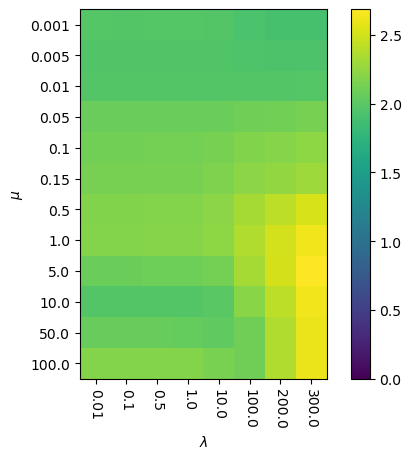

In [25]:
plt.figure()
plt.xticks(range(lambda_range.shape[0]),lambda_range, rotation=-90)
plt.yticks(range(mu_range.shape[0]),mu_range)
plt.ylabel(r'$\mu$')
plt.xlabel(r'$\lambda$')

plt.imshow(a_map_q95,vmin=0.0)

plt.colorbar()

plt.savefig("rmse_map_robust.png")
plt.show()

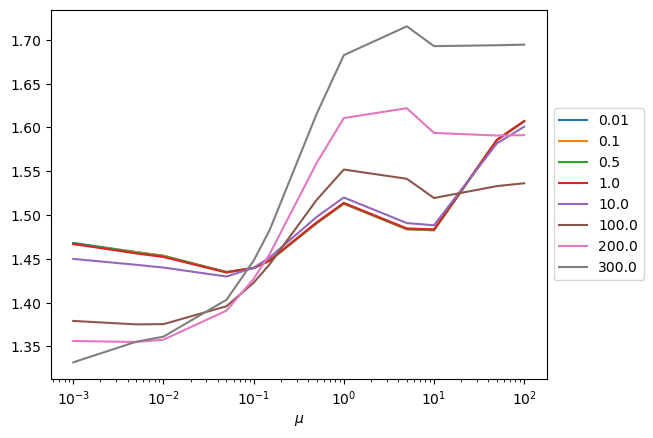

In [29]:
fig,ax  = plt.subplots()

for idx_lambda, lambda_ in enumerate(lambda_range):

    plt.plot(mu_range, a_map_mean[:,idx_lambda],label=str(lambda_))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xscale('log')

plt.xlabel(r'$\mu$')
plt.show()

# Get the best $\beta$ for robust model with the best pairs $\lambda$

In [32]:
a_map_ridge_mean = np.zeros(lambda_range.shape[0])

for idx_lambda, lambda_ in enumerate(lambda_range):
    a_map_ridge_mean[idx_lambda] = np.array(list(rmse_ridge_mean[(mu_,lambda_)].values())).mean()

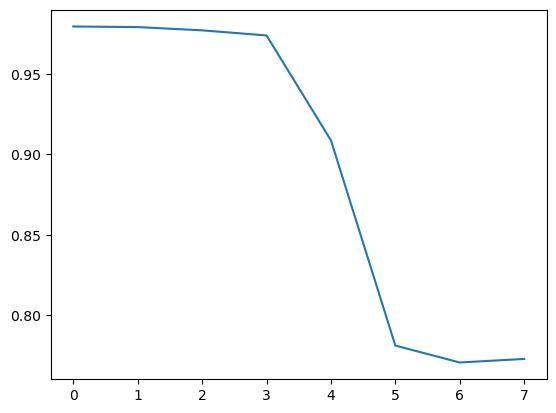

In [34]:
plt.figure()
plt.plot(a_map_ridge_mean)
plt.show()

In [35]:
beta_ridge_tmp = {} 

for idx_lambda, lambda_ in enumerate(lambda_range): 
    beta_ridge_tmp[lambda_] = 0
        
    for idx_m, m in enumerate(dic_reduced_ssp585.keys()):
        if idx_m == 0:
            beta_ridge_tmp[lambda_] = beta_ridge[(0.001,lambda_)][m]
        else:
            beta_ridge_tmp[lambda_] += beta_ridge[(0.001,lambda_)][m]

    beta_ridge_tmp[lambda_] = beta_ridge_tmp[lambda_]/len(list(dic_reduced_ssp585.keys()))

KeyError: 'FIO-ESM-2-0'

In [11]:
best_idx_lambda_ridge = np.argmin(a_map_ridge)
best_lambda_ridge = lambda_range[best_idx_lambda_ridge]
best_beta_ridge = beta_ridge_tmp[best_lambda_ridge]

# Get the best model with +/- $SE=\sqrt{\frac{\mathrm{Var}(LOO)}{M}}$

In [12]:
# compute the variance of the LOO
se_loo ={}

# for each pair (mu, lambda)
for idx_mu, mu_ in enumerate(mu_range):
    
    # for each lambda:
    for idx_lambda, lambda_ in enumerate(lambda_range):

        arr_tmp = np.array(list(rmse_robust[(mu_,lambda_)].values()))
        var_loo = np.var(arr_tmp)

        se_loo[(mu_,lambda_)] = np.sqrt(var_loo/len(rmse_robust[(mu_,lambda_)].keys()))

In [13]:
# compute the threshold = best_rmse + se_loo[best_pair] 
val_threshold = np.max(list(rmse_robust[(best_mu,best_lambda)].values())) + se_loo[(best_mu,best_lambda)]

# check all values below val_threshold
a_map_tmp = np.copy(a_map)
a_map_tmp[a_map_tmp > val_threshold] = 0.0

# get the indices of the non-zero elements
idx_mu, idx_lambda = np.where(a_map_tmp > 0)

# take the most regularized solution 
best_mu_robust = mu_range[idx_mu[-1]]
best_lambda_robust = lambda_range[idx_mu[-1]]

# Get the best $\beta$ for robust model with the best pairs (lambda, alpha)

In [14]:
beta_tmp = {} 

for idx_mu, mu_ in enumerate(mu_range):
    for idx_lambda, lambda_ in enumerate(lambda_range):
        beta_tmp[(mu_,lambda_)] = 0
        
        for idx_m, m in enumerate(dic_reduced_ssp585.keys()):
            if idx_m == 0:
                beta_tmp[(mu_,lambda_)] = beta_robust[(mu_,lambda_)][m]
            else:
                beta_tmp[(mu_,lambda_)] += beta_robust[(mu_,lambda_)][m]

        beta_tmp[(mu_,lambda_)] = beta_tmp[(mu_,lambda_)]/len(list(dic_reduced_ssp585.keys()))

In [15]:
best_beta_robust = beta_tmp[(best_mu_robust,best_lambda_robust)]
best_weights_robust = weights_robust[(best_mu_robust,best_lambda_robust)]
best_rmse_robust = rmse_robust[(best_mu_robust,best_lambda_robust)]

# plot the best betas and the best rmse

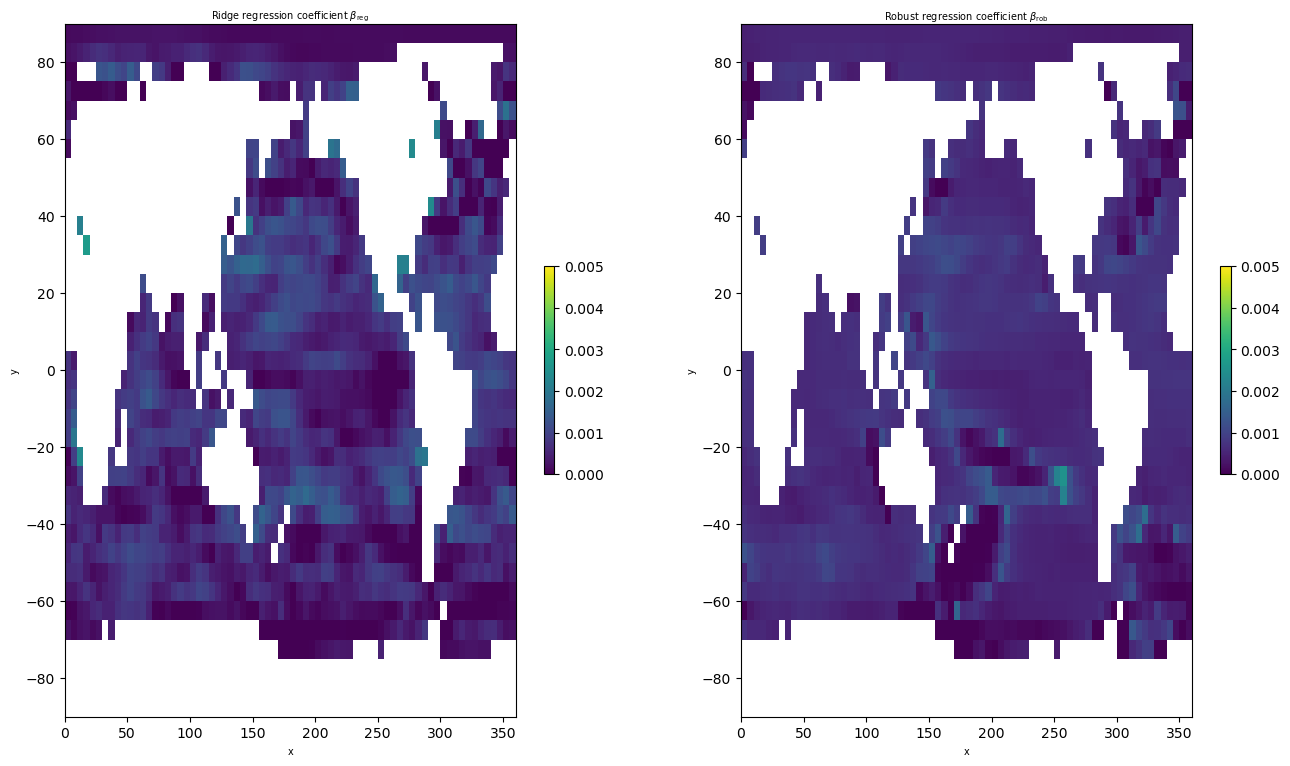

In [16]:
# define beta coefficient
best_beta_robust_tmp = best_beta_robust.detach().clone()
best_beta_robust_tmp[nan_idx] = float('nan')
beta_robust_to_plot = best_beta_robust_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)

best_beta_ridge_tmp = best_beta_ridge.detach().clone()
best_beta_ridge_tmp[nan_idx] = float('nan')
beta_ridge_to_plot = best_beta_ridge_tmp.detach().numpy().reshape(grid_lat_size,grid_lon_size)


############# plot the beta map for each leave-one-out run #####################################
fig0 = plt.figure(figsize=(16,9))           

ax0 = fig0.add_subplot(1, 2, 1) 
ax0.set_title(r'Ridge regression coefficient $\beta_{\mathrm{reg}}$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_ridge_to_plot,vmin=-0.00,vmax = 0.005)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(1, 2, 2)        
ax1.set_title(r'Robust regression coefficient $\beta_{\mathrm{rob}}$', size=7,pad=3.0)
im1 = ax1.pcolormesh(lon_grid,lat_grid,beta_robust_to_plot,vmin=-0.00,vmax = 0.005)
plt.colorbar(im1, ax=ax1, shrink=0.3)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

# ax2 = fig0.add_subplot(2, 2, 3)        
# ax2.set_title(r'Map difference', size=7,pad=3.0)
# im2 = ax2.pcolormesh(lon_grid,lat_grid,beta_robust_to_plot - beta_ridge_to_plot,vmin=-0.00,vmax = 0.001)
# plt.colorbar(im2, ax=ax2, shrink=0.3)
# ax2.set_xlabel(r'x', size=7)
# ax2.set_ylabel(r'y', size=7)
plt.savefig("DSmeeting_figures/beta_map.png")
plt.show()

/tmp/ipykernel_30082/4106298557.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


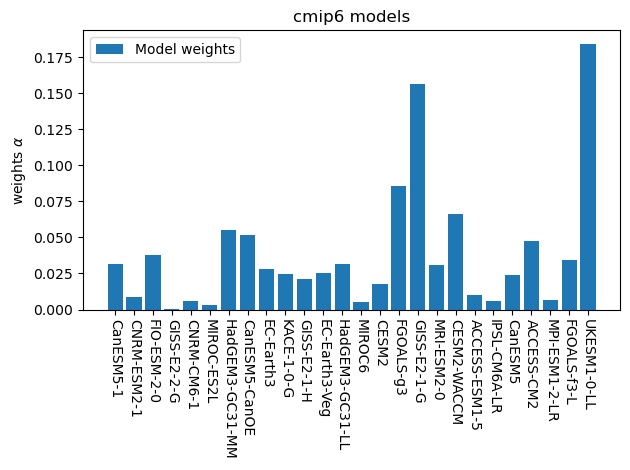

In [17]:
fig, ax = plt.subplots()
models = list(dic_reduced_ssp585.keys()) 
weights_plot = list(weights_robust[(best_mu_robust,best_lambda_robust)].values()) 
ax.bar(models, weights_plot,label='Model weights')
ax.set_ylabel(r'weights $\alpha$')
ax.set_title('cmip6 models')
ax.legend()
ax.set_xticklabels(models, rotation=-90)
plt.tight_layout()
plt.savefig("DSmeeting_figures/weights_best.png")
plt.show()

In [18]:
def compute_weights(x,y,vars,beta,lon_size,lat_size,models,mu_):
    """
    Plot and return the weights of the robust model.
    """
    M = len(list(dic_reduced_ssp585.keys()))
    gamma = torch.zeros(M)
    res = torch.zeros(M,33)
    
    for idx_m,m in enumerate(x.keys()):
        
        for idx_i, i in enumerate(x[m].keys()):
            res[idx_m,:] += (y[m][i] - torch.matmul(x[m][i],beta))**2/vars[m]
        res[idx_m,:] = res[idx_m,:]/len(x[m].keys())
        gamma[idx_m] = (1/mu_)*torch.mean(res[idx_m,:],axis=0)

    gamma = torch.nn.functional.softmax(gamma,dim=0)
    
    # plot the model contributions
    weights = {m: gamma[idx_m].item() for idx_m,m in enumerate(models)}

    return weights

In [19]:
weights_tmp = {}
for idx_mu, mu_ in enumerate(mu_range):
    
    for idx_lambda, lambda_ in enumerate(lambda_range):
        
        weights_tmp[(mu_,lambda_)] = compute_weights(x_train,y_train,variance_processed_ssp585,\
                                                        beta_tmp[(mu_,lambda_)],lon_size,lat_size,\
                                                        list(dic_reduced_ssp585.keys()),mu_)

In [20]:
best_mu_robust

0.05

## Compute the mean / worst case / quantile of LOO(m) 

In [21]:
# compute the loo 
rmse_robust_tmp =  np.array(list(rmse_robust[(best_mu_robust,best_lambda_robust)].values()))
rmse_ridge_tmp = np.array(list(rmse_ridge[(best_mu_robust,best_lambda_ridge)].values()))

# worst loo
worst_loo_robust = np.max(rmse_robust_tmp)
mean_loo_robust = np.mean(rmse_robust_tmp)

# quantile 95, 90, 75
q_loo_95_robust = np.quantile(rmse_robust_tmp, 0.95)
q_loo_90_robust = np.quantile(rmse_robust_tmp, 0.90)
q_loo_75_robust = np.quantile(rmse_robust_tmp, 0.75)
q_loo_50_robust = np.quantile(rmse_robust_tmp, 0.5)


# worst loo Ridge
worst_loo_ridge = np.max(rmse_ridge_tmp)
mean_loo_ridge = np.mean(rmse_ridge_tmp)

# quantiles for Ridge
q_loo_95_ridge = np.quantile(rmse_ridge_tmp, 0.95)
q_loo_90_ridge = np.quantile(rmse_ridge_tmp, 0.90)
q_loo_75_ridge = np.quantile(rmse_ridge_tmp, 0.75)
q_loo_50_ridge = np.quantile(rmse_ridge_tmp, 0.5)


print("======= Statistics ========")
print("\n")
print("          Robust Ridge")
print("0.95:     {:.3f}  {:.3f}".format(q_loo_95_robust,q_loo_95_ridge))
print("0.90:     {:.3f}  {:.3f}".format(q_loo_90_robust,q_loo_90_ridge))
print("0.75:     {:.3f}  {:.3f}".format(q_loo_75_robust,q_loo_75_ridge))
print("Median:   {:.3f}  {:.3f}".format(q_loo_50_robust,q_loo_50_ridge))
print("Mean:     {:.3f}  {:.3f}".format(mean_loo_robust,mean_loo_ridge))
print("Worst:    {:.3f}  {:.3f}".format(worst_loo_robust,worst_loo_ridge))

======= Statistics ========


          Robust Ridge
0.95:     1.149  1.525
0.90:     0.994  1.249
0.75:     0.865  0.995
Median:   0.772  0.665
Mean:     0.995  1.185
Worst:    5.999  11.579


# Plot the training loss with varying μ

In [22]:
training_loss_tmp = training_loss.copy()

# for each pair (mu, lambda)
for idx_mu, mu_ in enumerate(mu_range):
    
    # for each lambda:
    for idx_lambda, lambda_ in enumerate(lambda_range):

        training_loss_tmp[(mu_,lambda_)] = np.sum(list(training_loss[(mu_,lambda_)].values()),axis=0)/(len(x_predictor.keys())-1)

# Generate the gif for varying $\mu$

## generate a gif for a single $\lambda$ value

In [23]:
from matplotlib import animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()


x= list(dic_processed_ssp585.keys())
barcollection = plt.bar(x,list(np.ones(len(x))))
ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
ax.set_ylim(0.0,10.0)


def animate_rmse(i):
    ax.set_title(r' $\mu$ = '+ str(mu_range[mu_range.shape[0]-1-i])+ ', $\lambda$ = '+ str(lambda_range[best_idx_lambda]))
    for k, b in enumerate(barcollection):
        b.set_height(list(rmse_robust[(mu_range[mu_range.shape[0]-1-i],lambda_range[best_idx_lambda])].values())[k])
    
animation.FuncAnimation(fig, animate_rmse, frames=mu_range.shape[0])
# ani_rmse.save('figures/robust_loo_rmse.mp4',writer=animation.FFMpegWriter(fps=2))

/tmp/ipykernel_30082/3383942582.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)


In [24]:
fig, ax = plt.subplots()

x= list(dic_processed_ssp585.keys())
barcollection = plt.bar(x,list(np.ones(len(x))))
ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
ax.set_ylim(0.0,11.0)


def animate_rmse(i):
    ax.set_title(r' $\lambda$ = '+ str(lambda_range[lambda_range.shape[0]-1-i]))
    for k, b in enumerate(barcollection):
        b.set_height(list(rmse_ridge[(0.1,lambda_range[lambda_range.shape[0]-1-i])].values())[k])
    
animation.FuncAnimation(fig, animate_rmse, frames=lambda_range.shape[0])
# ani_rmse.save('figures/robust_loo_rmse.mp4',writer=animation.FFMpegWriter(fps=2))

/tmp/ipykernel_30082/323130686.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)


# Plot the weight as a gif

In [26]:
fig, ax = plt.subplots()

x= list(dic_processed_ssp585.keys())
barcollection = plt.bar(x,list(np.ones(len(x))))
ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
ax.set_ylim(0.0,0.2)

def animate_weight(i):
    ax.set_title(r'Model mean weights for $\mu$ = '+ str(mu_range[mu_range.shape[0]-1-i])+ ', $\lambda$ = '+ str(lambda_range[best_idx_lambda]) + ', RMSE: '+ str(a_map[mu_range.shape[0]-1-i,best_idx_lambda]))
    for k, b in enumerate(barcollection):
        b.set_height(list(weights_robust[(mu_range[mu_range.shape[0]-1-i],lambda_range[best_idx_lambda])].values())[k])

animation.FuncAnimation(fig, animate_weight, frames=mu_range.shape[0])


/tmp/ipykernel_30082/3938787483.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)


## generate a gif to observe the training loss 

In [27]:
fig, ax = plt.subplots()

x= list(dic_processed_ssp585.keys())
barcollection = plt.bar(x,list(np.ones(len(x))))
ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
ax.set_ylim(0.0,2.0)

def animate_weight(i):
    ax.set_title(r'Training loss for $\mu$ = '+ str(mu_range[mu_range.shape[0]-1-i])+ ', $\lambda$ = '+ str(lambda_range[best_idx_lambda]) + ', RMSE: '+ str(a_map[mu_range.shape[0]-1-i,best_idx_lambda]))
    for k, b in enumerate(barcollection):
        b.set_height(training_loss_tmp[(mu_range[mu_range.shape[0]-1-i],lambda_range[best_idx_lambda])][k])

animation.FuncAnimation(fig, animate_weight, frames=mu_range.shape[0])
# ani_training_loss.save('figures/robust_training_loss.mp4',writer=animation.FFMpegWriter(fps=2))

/tmp/ipykernel_30082/217397468.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
